## Load pre-trained model and processor

Let's first apply the image preprocessing and tokenize the text queries using `OwlViTProcessor`. The processor will resize the image(s), scale it between [0-1] range and normalize it across the channels using the mean and standard deviation specified in the original codebase.


Text queries are tokenized using a CLIP tokenizer and stacked to output tensors of shape [batch_size * num_max_text_queries, sequence_length]. If you are inputting more than one set of (image, text prompt/s), num_max_text_queries is the maximum number of text queries per image across the batch. Input samples with fewer text queries are padded.

In [3]:
from transformers import Owlv2Processor, Owlv2ForObjectDetection
from transformers import OwlViTProcessor, OwlViTForObjectDetection

processor = Owlv2Processor.from_pretrained("google/owlv2-base-patch16-ensemble", do_pad = False)
model = Owlv2ForObjectDetection.from_pretrained("google/owlv2-base-patch16-ensemble")
# model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")
# processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")


2024-03-12 18:39:56.936697: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-12 18:39:56.974090: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-12 18:39:56.974118: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-12 18:39:56.974962: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-12 18:39:56.980807: I tensorflow/core/platform/cpu_feature_guar

Client Start
save image!


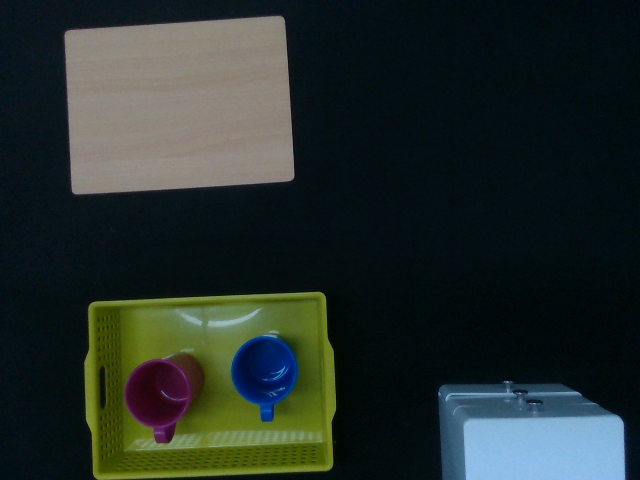

In [2]:
import cv2
import numpy as np
from PIL import Image

import zmq
import json
import cv2
import torch

context = zmq.Context()
socket = context.socket(zmq.REQ)  # REQ (REQUEST) 소켓
socket.connect("tcp://115.145.175.206:5555")
print("Client Start")
action = 0 # oracle_action()

action_json = json.dumps(action)
socket.send_string(action_json)

data = socket.recv_string()
data = json.loads(data)

rgb_array = np.array(data['rgb'])
rgb_path = '/home/pjw971022/Sembot/real_bot/save_vision/obs/image_obs.png'
cv2.imwrite(rgb_path, rgb_array)
print("save image!")

image = Image.open(rgb_path).convert("RGB")

image

In [96]:
from custom_utils.llm_utils import *
from PIL import Image

llm_agent = LLMAgent(True)
image_path = '/home/pjw971022/Sembot/real_bot/save_viz/obs/image_obs.png'
obs_img = Image.open(image_path)
# obs_front_img = Image.open('/home/pjw971022/Sembot/real_bot/save_viz/obs/packing_shapes_front.jpg')
categories_prompt = "Tell me every objects in the black table."
context = llm_agent.gemini_generate_context(categories_prompt, obs_img)

@@@ gen context:   There are 13 objects on the black table. They are the letters O, T, U, S, Y, B, H, X, M, and R.


In [4]:
import string
text_queries = ["red cup", "blue cup", "coffee stick"]
# text_queries = [ 'letter B', 'letter D', 'letter E', 'letter F', 'letter G', 'letter H',
#  'letter J', 'letter K', 'letter L', 'letter M', 'letter O', 'letter V', 'letter R', 
#   'letter T', 'letter U', 'letter V', 'letter S', 'letter X', 'letter Y', 'letter Z']
print(text_queries)
# text_queries = ['A', 'B','C','D','E','F','G','H','I',
 #['Circular cap','pill bottle circular cap', 'plastic bottle',]#,'baseball', 'cup', 'dice', 'pencil', 'plastic spoon', 'soda can', 'tennis ball']
# text_queries = ['baseball', 'cup', 'dice', 'pencil', 'plastic spoon', 'soda can', 'tennis ball']
# text_queries = ['sponge','rectangular prism','red block', 'green block', 'yellow block', 'bottle', 'lotion', 'cup', 'sponge', 'pencil holder', 'yellow pencil',
#                 'green basket', 'stain', 'toy car' ,'baseball', 'handcream','pump','shampoo', 'tennis ball' ] #objects # ['G', 'O', 'F', 'D', 'E', 'M', 'R']# , 
# text_queries = ["circle shape", "rectangle shape",  "ring shape", "square shape", "stick shape"]
# text_queries = ["trash", "snack", "food", "office supplies", "toy", "tools", "kitchenware", "fan"]
inputs = processor(text=text_queries, images=image, return_tensors="pt").to(device)

# Print input names and shapes
for key, val in inputs.items():
    print(f"{key}: {val.shape}")


['red cup', 'blue cup', 'coffee stick']
input_ids: torch.Size([3, 16])
attention_mask: torch.Size([3, 16])
pixel_values: torch.Size([1, 3, 960, 960])


## Forward pass

Now we can pass the inputs to our OWL-ViT model to get object detection predictions.

`OwlViTForObjectDetection` model outputs the prediction logits, boundary boxes and class embeddings, along with the image and text embeddings outputted by the `OwlViTModel`, which is the CLIP backbone.

In [10]:
# Set model in evaluation mode
model = model.to(device)
model.eval()

# Get predictions
with torch.no_grad():
  outputs = model(**inputs)
# Threshold to eliminate low probability predictions
score_threshold = 0.05


import matplotlib.pyplot as plt

from transformers.image_utils import ImageFeatureExtractionMixin
mixin = ImageFeatureExtractionMixin()

# # Load example image
image_size = model.config.vision_config.image_size
print(image)
image = mixin.resize(image, image_size)
input_image = np.asarray(image).astype(np.float32) / 255.0

target_sizes = torch.Tensor([image.size[::-1]])
print(target_sizes)

# Get prediction logits
logits = torch.max(outputs["logits"][0], dim=-1)
scores = torch.sigmoid(logits.values).cpu().detach().numpy()

# Get prediction labels and boundary boxes
labels = logits.indices.cpu().detach().numpy()
boxes = outputs["pred_boxes"][0].cpu().detach().numpy()
# results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=score_threshold)

# print(f"box: {results[0]['boxes'][2]}")
# print(f"score: {results[0]['scores'][2]}")

<PIL.Image.Image image mode=RGB size=960x960 at 0x7F8785917D30>
tensor([[960., 960.]])


## Draw predictions on image

Let's draw the predictions / found objects on the input image. Remember the found objects correspond to the input text queries.

label: coffee stick     score: 0.05311562865972519    box pose: [0.5000116  0.2731416  0.0347534  0.13793063]
label: coffee stick     score: 0.05851946026086807    box pose: [0.821169   0.32045797 0.04799961 0.06323145]
label: blue cup     score: 0.1546134054660797    box pose: [0.7127393  0.35364625 0.10952446 0.14454332]
label: blue cup     score: 0.266588419675827    box pose: [0.8700572  0.36037886 0.14180522 0.1474475 ]
label: red cup     score: 0.07811982184648514    box pose: [0.8835983  0.36182317 0.11292722 0.14361805]
label: blue cup     score: 0.5139595866203308    box pose: [0.70586157 0.36260906 0.12643747 0.16515793]


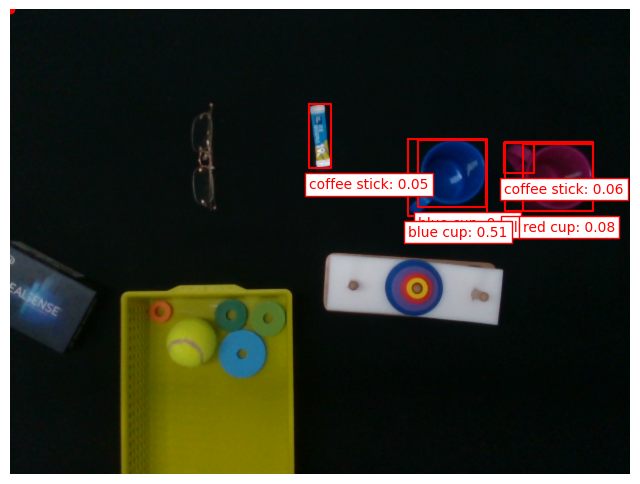

In [11]:
def plot_predictions(input_image, text_queries, scores, boxes, labels, detected_image_path):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(input_image, extent=(0, 1.0, 0.75, 0))
    ax.set_axis_off()
    ax.plot(0., 0.0,'ro')
    for score, box, label in zip(scores, boxes, labels):
      if score < score_threshold:
        continue
      else:
        print(f'label: {text_queries[label]}     score: {score}    box pose: {box}')
      cx, cy, w, h = box
      cy *= 0.75
      h *= 0.75
      ax.plot([cx-w/2, cx+w/2, cx+w/2, cx-w/2, cx-w/2],
              [cy-h/2, cy-h/2, cy+h/2, cy+h/2, cy-h/2], "r")
      ax.text(
          cx - w / 2,
          cy + h / 2 + 0.015,
          f"{text_queries[label]}: {score:1.2f}",
          ha="left",
          va="top",
          color="red",
          bbox={
              "facecolor": "white",
              "edgecolor": "red",
              "boxstyle": "square,pad=.3"
          })

    plt.savefig(detected_image_path)
detected_image_path = '/home/pjw971022/Sembot/real_bot/save_vision/obs/detected_obs.png' 
resized_image = cv2.resize(input_image, (640, 480))
resized_image.shape

plot_predictions(resized_image, text_queries, scores, boxes, labels, detected_image_path)    
# plot_predictions(input_image, virtualhome_text_queries, scores, boxes, labels, detected_image_path)
# X/T/M/B/R/H/U/O/V/Y/S

In [102]:

def extract_points_within_bbox(point_cloud, bbox):
    """
    Extract points from a point cloud that are within the given bounding box.

    Parameters:
    - point_cloud (np.array): The point cloud as a numpy array of shape (480, 640, 3).
    - bbox (tuple): The bounding box specified as (cx, cy, w, h), where cx and cy are the
                    coordinates of the center, and w and h are the width and height.

    Returns:
    - np.array: A filtered point cloud containing only the points within the bounding box.
    """
    cx, cy, w, h = bbox
    cx *= 640
    cy *= 480
    w *= 640
    h *= 480
    rows, cols, _ = point_cloud.shape

    # Calculate the bounds of the bounding box
    x_min = max(int(cx - w / 2), 0)
    x_max = min(int(cx + w / 2), cols)
    y_min = max(int(cy - h / 2), 0)
    y_max = min(int(cy + h / 2), rows)

    # Create a mask for points within the bounding box
    y_indices, x_indices = np.ogrid[:rows, :cols]
    mask = (x_indices >= x_min) & (x_indices < x_max) & (y_indices >= y_min) & (y_indices < y_max)

    # Filter the point cloud based on the mask
    filtered_points = point_cloud[mask]

    return filtered_points

# g_bbox = [0.88,  0.57,  0.0670583,  0.06833385]
# y_bbox = [0.52,  0.57,   0.05145311, 0.06556407]
# r_bbox = [0.52,  0.09, 0.05009488, 0.08601852]

def transform_coordinates(x, y): # @
    # transform pixel pose with robot coordinate
    new_x = y + 0.55
    new_y = x - 0.13

    return new_x, new_y


def transform_franka_pose(bbox, pointcloud_array):
    filtered_pc = extract_points_within_bbox(pointcloud_array.reshape(rgb_array.shape), bbox)
    filtered_pc = filtered_pc[filtered_pc[:, -1] > 0]
    sorted_array_by_z = filtered_pc[filtered_pc[:, -1].argsort()]  # Z 값 기준으로 정렬
    bottom_10_by_z = sorted_array_by_z[:500]  # Z 값이 가장 작은 하위 10개 선택
    selected_point = np.mean(bottom_10_by_z, axis=0)

    # min_idx = filtered_pc[:,-1].argmin()
    # selected_point = filtered_pc[min_idx]
    # argmin: (0.44239964169263835, 0.1612999939918518) 
    pose = transform_coordinates(selected_point[0], selected_point[1],)
    pose_z = 0.863 - selected_point[2]
    print(bottom_10_by_z)
    return pose[0], pose[1], pose_z 

bbox =[0.5192626,  0.4542763,  0.05165405, 0.0669348 ]
# y_block_bbox = [0.9267224,  0.3878523,  0.03709006, 0.08764208]
pose = transform_franka_pose(bbox, pointcloud_array)
print(pose)




[[-0.00633954 -0.03955433  0.79800004]
 [-0.0076496  -0.04086671  0.79800004]
 [-0.00633954 -0.03692955  0.79800004]
 ...
 [-0.00377534 -0.05480249  0.81000006]
 [ 0.01750086 -0.02283152  0.81000006]
 [ 0.01617109 -0.02283152  0.81000006]]
(0.5158737190924585, -0.1266006345282076, 0.058591963171958916)


In [18]:
pointcloud_array.shape

(307200, 3)

In [ ]:
import open3d as o3d
import numpy as np
import plotly.graph_objects as go
import os
from copy import deepcopy
os.environ["TOKENIZERS_PARALLELISM"] = "false"

def show_point_cloud(points, color_axis, bbox=None,  width_size=1000, height_size=600, coordinate_frame=True):
    '''
    points : (N, 3) size of ndarray
    color_axis : 0, 1, 2
    '''
    assert points.shape[1] == 3
    assert color_axis==0 or color_axis==1 or color_axis==2   
    
    min_value = 0.0
    max_value = 0.1
    # color 값을 해당 범위로 제한
    clipped_colors = np.clip(points[:, color_axis], min_value, max_value)

    # Create a scatter3d Plotly plot
    plotly_fig = go.Figure(data=[go.Scatter3d(
        x=points[:, 0],
        y=points[:, 1],
        z=points[:, 2],
        mode='markers',
        marker=dict(
            size=1,
            color=clipped_colors, # Set color based on Z-values
            colorscale='jet', # Choose a color scale
            colorbar=dict(title='value') # Add a color bar with a title
        )
    )])

    x_range = points[:, 0].max()*0.8 - points[:, 0].min()*0.8
    y_range = points[:, 1].max()*0.8 - points[:, 1].min()*0.8
    z_range = points[:, 2].max()*0.8 - points[:, 2].min()*0.8

    # Adjust the Z-axis scale
    plotly_fig.update_layout(
        scene=dict(
            aspectmode='manual',
            aspectratio=dict(x=x_range, y=y_range, z=z_range), # Here you can set the scale of the Z-axis     
            camera=dict(
                eye=dict(x=0.5, y=0.5, z=0.2)  # 카메라의 위치 조정
            )
        ),
        width=width_size, # Width of the figure in pixels
        height=height_size, # Height of the figure in pixels
        showlegend=False
    )
    
    if coordinate_frame:
        # Length of the axes
        axis_length = 1

        # Create lines for the axes
        lines = [
            go.Scatter3d(x=[0, axis_length], y=[0, 0], z=[0, 0], mode='lines', line=dict(color='red')),
            go.Scatter3d(x=[0, 0], y=[0, axis_length], z=[0, 0], mode='lines', line=dict(color='green')),
            go.Scatter3d(x=[0, 0], y=[0, 0], z=[0, axis_length], mode='lines', line=dict(color='blue'))
        ]

        # Create cones (arrows) for the axes
        cones = [
            go.Cone(x=[axis_length], y=[0], z=[0], u=[axis_length], v=[0], w=[0], sizemode='absolute', sizeref=0.1, anchor='tail', showscale=False),
            go.Cone(x=[0], y=[axis_length], z=[0], u=[0], v=[axis_length], w=[0], sizemode='absolute', sizeref=0.1, anchor='tail', showscale=False),
            go.Cone(x=[0], y=[0], z=[axis_length], u=[0], v=[0], w=[axis_length], sizemode='absolute', sizeref=0.1, anchor='tail', showscale=False)
        ]

        # Add lines and cones to the figure
        for line in lines:
            plotly_fig.add_trace(line)
        for cone in cones:
            plotly_fig.add_trace(cone)


    # Add Bounding box in figure
    if bbox is not None:
        cx,cy,w,h = bbox
        bbox_min = [cx-w/2, cy-h/2, 0.0]
        bbox_max = [cx+w/2, cy+h/2, 0.1]

        bbox_vertices = np.array([
            [bbox_min[0], bbox_min[1], bbox_min[2]],
            [bbox_min[0], bbox_min[1], bbox_max[2]],
            [bbox_min[0], bbox_max[1], bbox_min[2]],
            [bbox_min[0], bbox_max[1], bbox_max[2]],
            [bbox_max[0], bbox_min[1], bbox_min[2]],
            [bbox_max[0], bbox_min[1], bbox_max[2]],
            [bbox_max[0], bbox_max[1], bbox_min[2]],
            [bbox_max[0], bbox_max[1], bbox_max[2]],
        ])

        i = [0, 0, 0, 1, 1, 2, 2, 3, 4, 4, 4, 5, 5, 6, 6, 7]
        j = [1, 2, 4, 3, 5, 3, 6, 7, 5, 6, 0, 7, 1, 7, 2, 3]
        k = [3, 6, 5, 7, 7, 7, 7, 7, 6, 2, 1, 3, 5, 3, 4, 2]
        
        plotly_fig.add_trace(go.Mesh3d(
            x=bbox_vertices[:, 0],
            y=bbox_vertices[:, 1],
            z=bbox_vertices[:, 2],
            i=i,
            j=j,
            k=k,
            color='#FFB6C1',
            opacity=0.5
        ))


    # Show the plot
    plotly_fig.show()

pc_array = deepcopy(pointcloud_array)
pc_array[:,2] = 0.85 - pc_array[:,2] 
baseball_bbox = [0.68078583, 0.31387693, 0.0932375,  0.1164256 ]
tennisball_bbox = [0.7472204,  0.8204705,  0.08430256, 0.11234711]
def transform_bbox(bbox):
    bbox[0] *= -1
    bbox[1] *= -1
    bbox[1] *= 0.75
    bbox[3] *= 0.75

    bbox = [ p * 0.65 for p in bbox]
    bbox[0] += 0.6
    bbox[1] += 0.1
    print(bbox)
    return bbox

# transform_bbox(baseball_bbox)
# transform_bbox(tennisball_bbox)

# new_x, new_y = transform_coordinates(baseball_bbox[0], baseball_bbox[1])
# baseball_bbox[0] = new_x
# baseball_bbox[1] = new_y
# 0.17, -0.12
# 0 , -0.3
show_point_cloud(pc_array, 2)